#### Copyright 2018 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Intro to Modeling


**Learning Objectives:**
* Become familiar with pandas for handling small datasets
* Use the tf.Estimator and Feature Column API to experiment with feature transformations
* Use visualizations and run experiments to understand the value of feature transformations

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's start by importing our dependencies.

In [1]:
%reset -f
import numpy as np
import pandas as pd
import math

!pip install tensorflow==2.15
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Pandas, a helpful data analysis library for in-memory dataset

We use a package called [Pandas](http://pandas.pydata.org/) for reading in our data, exploring our data and doing some basic processing. It is really helpful for datasets that fit in memory! And it has some nice integrations, as you will see.

First we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

In [2]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.


In [4]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [5]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
6,1,158,audi,gas,std,four,sedan,fwd,front,105.80,...,136,mpfi,3.19,3.40,8.50,110,5500,19,25,17710
131,2,?,renault,gas,std,two,hatchback,fwd,front,96.10,...,132,mpfi,3.46,3.90,8.70,?,?,23,31,9895
140,2,83,subaru,gas,std,two,hatchback,4wd,front,93.30,...,108,2bbl,3.62,2.64,8.70,73,4400,26,31,7603


In [9]:
#@title Solution (to view code, from cell's menu, select Form -> Show Code)
Label = 'price'
numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [10]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
47,0,145,113.00,199.60,69.60,52.80,4066,258,176,4750,15,19,3.63,4.17,8.10
109,0,?,114.20,198.90,68.40,58.70,3230,120,97,5000,19,24,3.46,3.19,8.40
187,2,94,97.30,171.70,65.50,55.70,2319,97,68,4500,37,42,3.01,3.40,23.00
79,1,161,93.00,157.30,63.80,50.80,2145,98,102,5500,24,30,3.03,3.39,7.60
6,1,158,105.80,192.70,71.40,55.70,2844,136,110,5500,19,25,3.19,3.40,8.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,-2,103,104.30,188.80,67.20,56.20,2912,141,114,5400,23,28,3.78,3.15,9.50
162,0,91,95.70,166.30,64.40,52.80,2140,98,70,4800,28,34,3.19,3.03,9.00
147,0,89,97.00,173.50,65.40,53.00,2455,108,94,5200,25,31,3.62,2.64,9.00
130,0,?,96.10,181.50,66.50,55.20,2579,132,?,?,23,31,3.46,3.90,8.70


In [11]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,num-doors,fuel-type,make,body-style,engine-location,fuel-system,engine-type,aspiration,num-cylinders,drive-wheels
47,four,gas,jaguar,sedan,front,mpfi,dohc,std,six,rwd
109,four,gas,peugot,wagon,front,mpfi,l,std,four,rwd
187,four,diesel,volkswagen,sedan,front,idi,ohc,turbo,four,fwd
79,two,gas,mitsubishi,hatchback,front,spdi,ohc,turbo,four,fwd
6,four,gas,audi,sedan,front,mpfi,ohc,std,five,fwd
...,...,...,...,...,...,...,...,...,...,...
194,four,gas,volvo,sedan,front,mpfi,ohc,std,four,rwd
162,four,gas,toyota,sedan,front,2bbl,ohc,std,four,fwd
147,four,gas,subaru,wagon,front,mpfi,ohcf,std,four,fwd
130,four,gas,renault,wagon,front,mpfi,ohc,std,four,fwd


In [12]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [Label]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [13]:
#@title Possible solution
# Here is one possible solution:
# The only necessary change to fix the NaN training loss was the choice of optimizer.

# Changing other parameters could improve model quality, but take it with a
# grain of salt. The dataset is very small.

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Feature columns allow the model to parse the data, perform common
# preprocessing, and automatically generate an input layer for the tf.Estimator.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=t

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


scores {'average_loss': 40842704.0, 'label/mean': 12949.43, 'loss': 644058050.0, 'prediction/mean': 12960.303, 'global_step': 1000}


Instructions for updating:
Use standard file utilities to get mtimes.


scores {'average_loss': 32185968.0, 'label/mean': 12949.43, 'loss': 507547970.0, 'prediction/mean': 12935.376, 'global_step': 2000}
scores {'average_loss': 27904612.0, 'label/mean': 12949.43, 'loss': 440034270.0, 'prediction/mean': 13210.623, 'global_step': 3000}
scores {'average_loss': 25940822.0, 'label/mean': 12949.43, 'loss': 409066800.0, 'prediction/mean': 13193.525, 'global_step': 4000}


Instructions for updating:
Use standard file APIs to delete files with this prefix.


scores {'average_loss': 24972126.0, 'label/mean': 12949.43, 'loss': 393791200.0, 'prediction/mean': 13206.464, 'global_step': 5000}
scores {'average_loss': 24417120.0, 'label/mean': 12949.43, 'loss': 385039200.0, 'prediction/mean': 13104.005, 'global_step': 6000}
scores {'average_loss': 24063816.0, 'label/mean': 12949.43, 'loss': 379467840.0, 'prediction/mean': 13063.778, 'global_step': 7000}
scores {'average_loss': 23790238.0, 'label/mean': 12949.43, 'loss': 375153730.0, 'prediction/mean': 12998.925, 'global_step': 8000}
scores {'average_loss': 23529422.0, 'label/mean': 12949.43, 'loss': 371040900.0, 'prediction/mean': 13098.212, 'global_step': 9000}
scores {'average_loss': 23301930.0, 'label/mean': 12949.43, 'loss': 367453500.0, 'prediction/mean': 13082.155, 'global_step': 10000}


### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


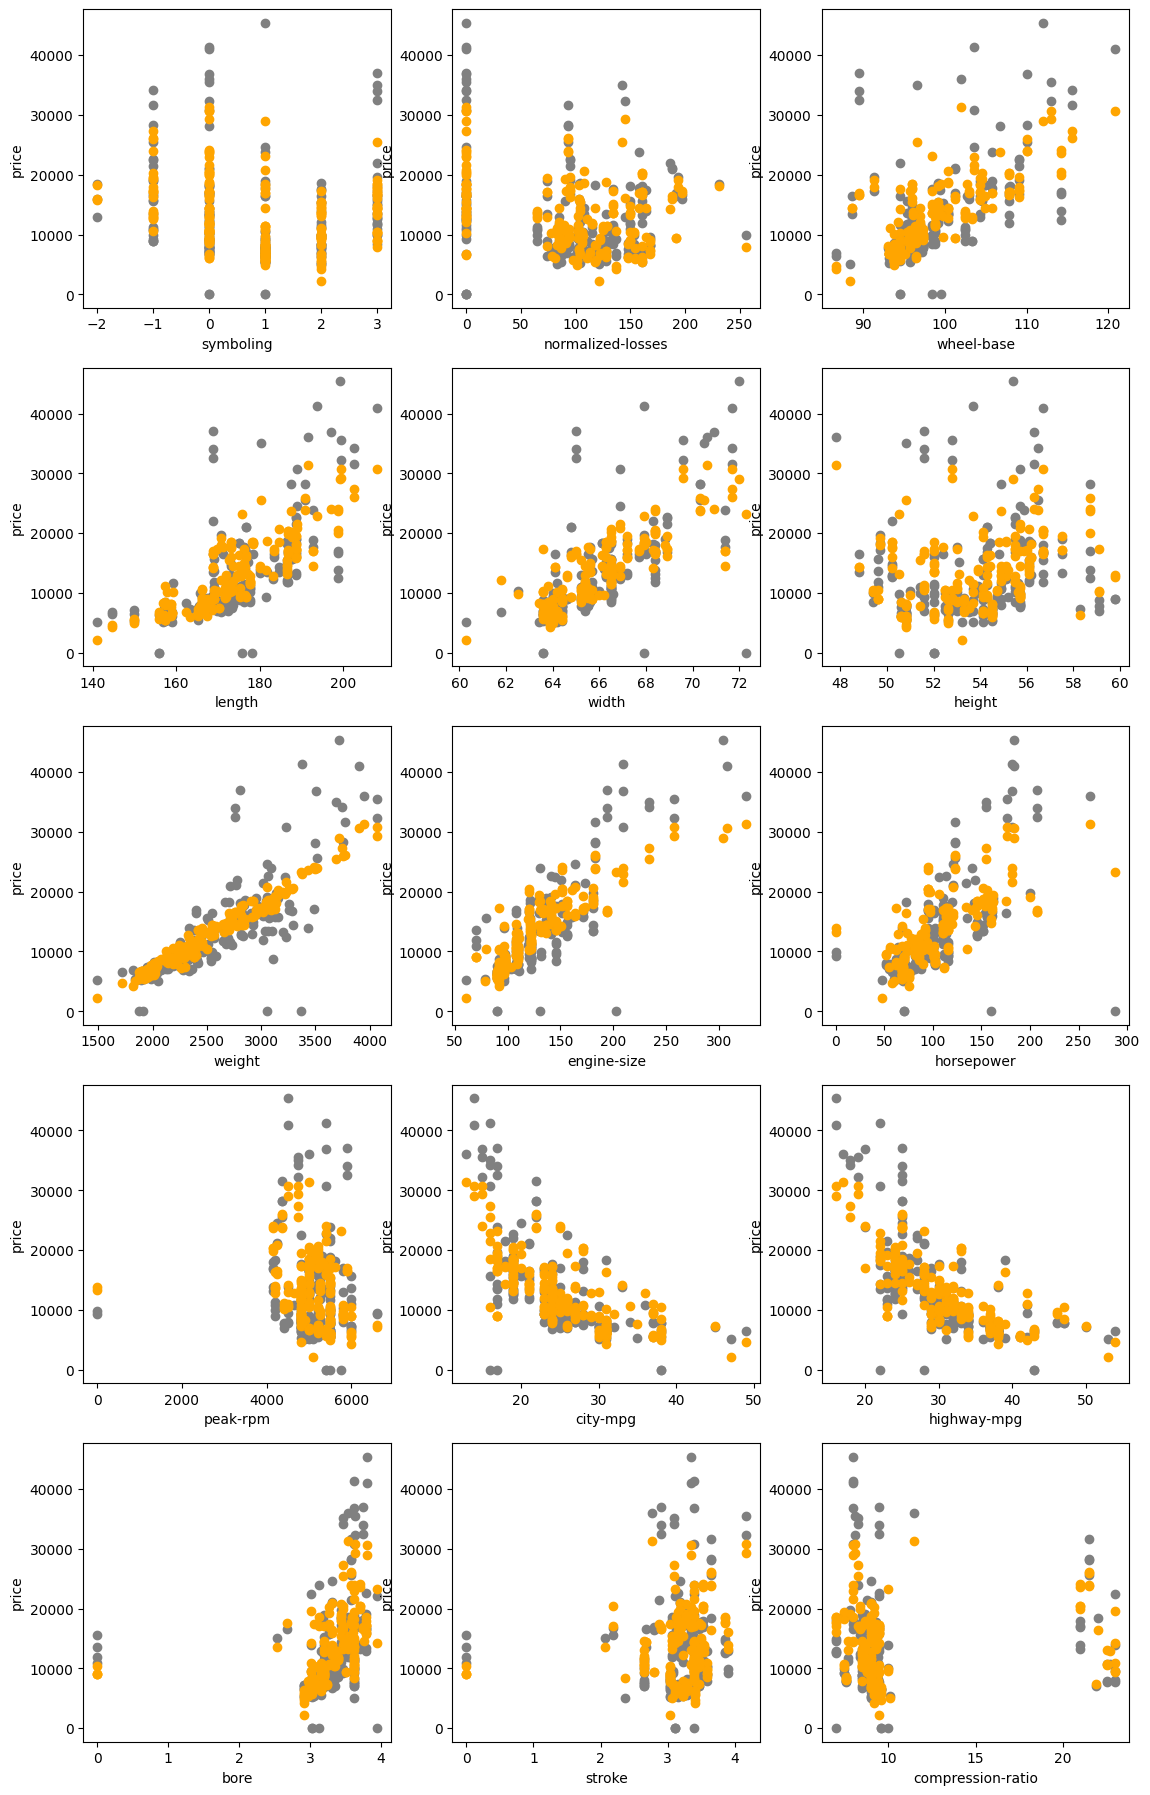

In [14]:
from matplotlib import pyplot as plt


def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.

  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]

  num_cols = 3
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)

  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 2: Take your best numeric model from earlier. Add normalization.

### Add normalization to your best numeric model from earlier

- You decide what type of normalization to add, and for which features
- You will need to use the `normalizer_fn` arg on [`numeric_column`](https://g3doc.corp.google.com/learning/brain/public/g3doc/api_docs/python/tf/feature_column/numeric_column.md?cl=head)
    - An example of a silly normalizer_fn that shifts inputs down by 1, and then negates the value:
    
         normalizer_fn = lambda x: tf.neg(tf.subtract(x, 1))

- You may find these pandas functions helpful:
    - dataframe.mean()['your_feature_name']
    - dataframe.std()['your_feature_name']
- You will need to retune the hyperparameters from earlier.


**Does normalization improve model quality on this dataset? Why or why not?**

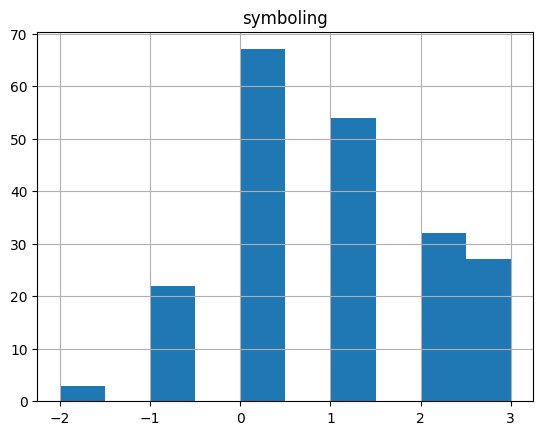

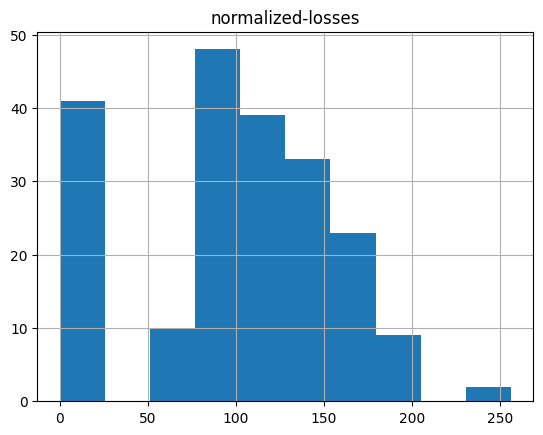

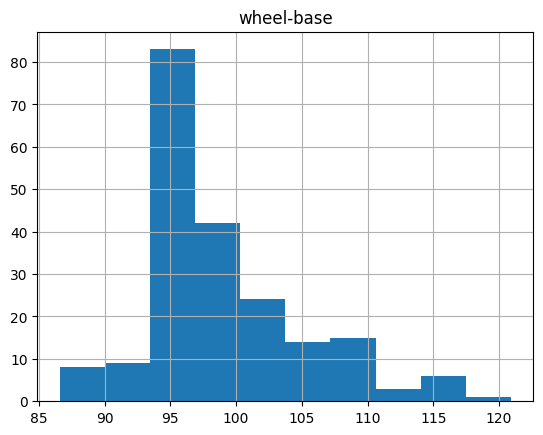

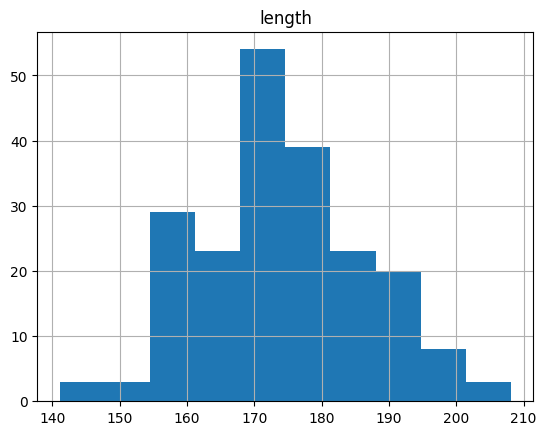

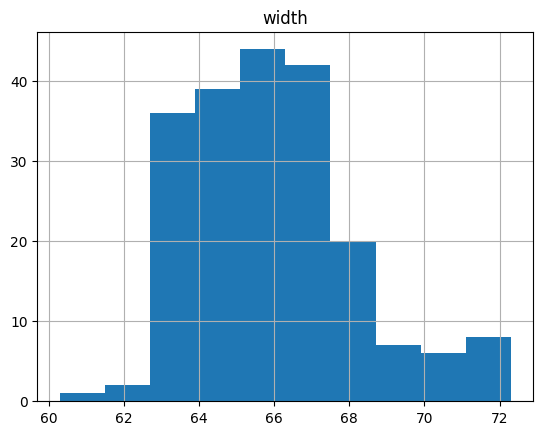

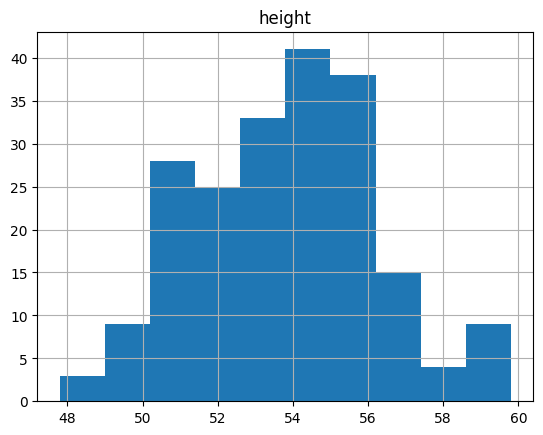

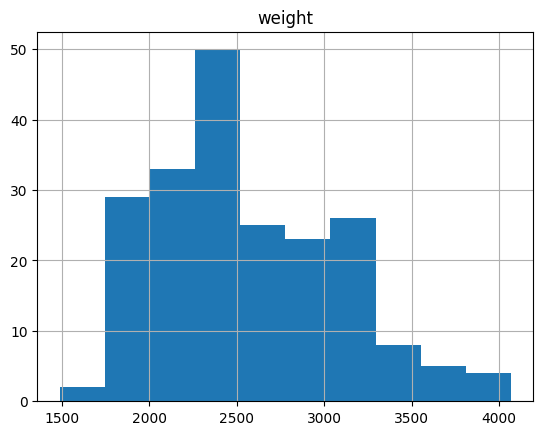

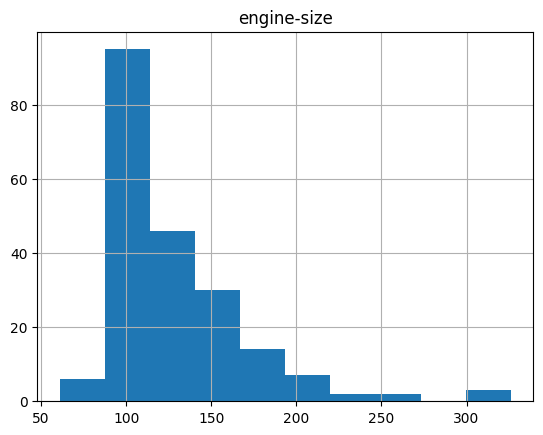

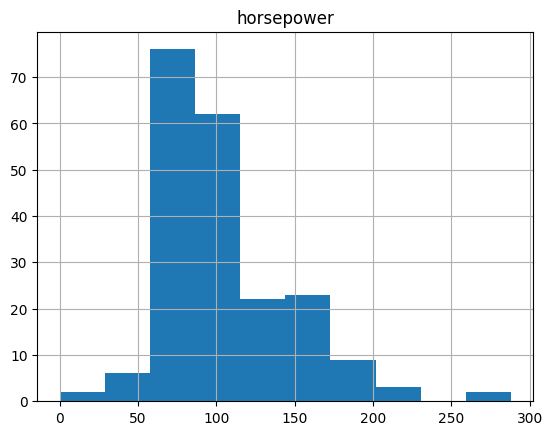

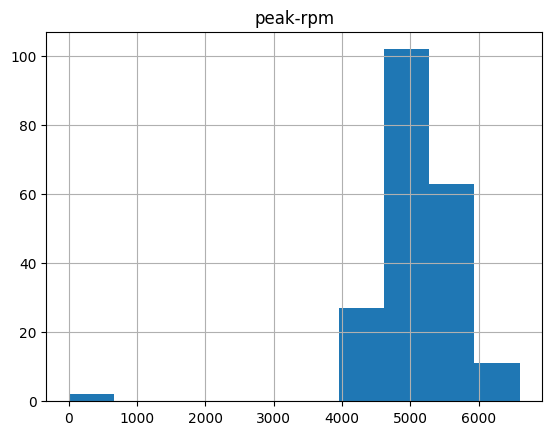

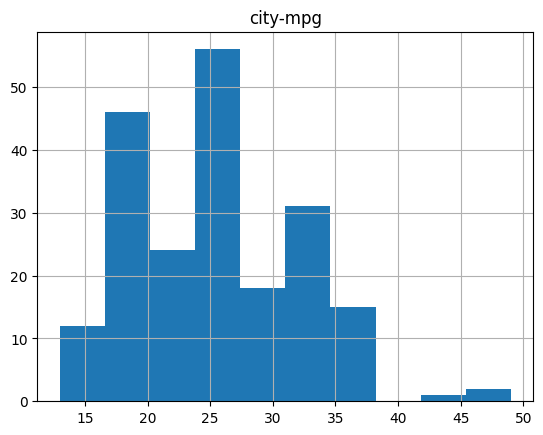

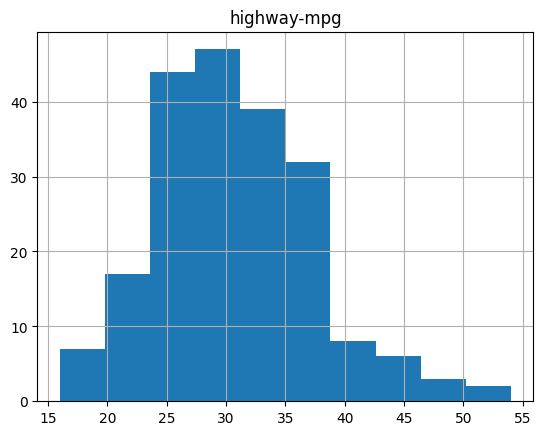

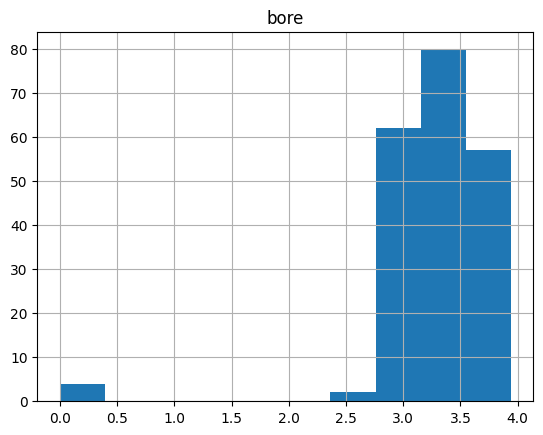

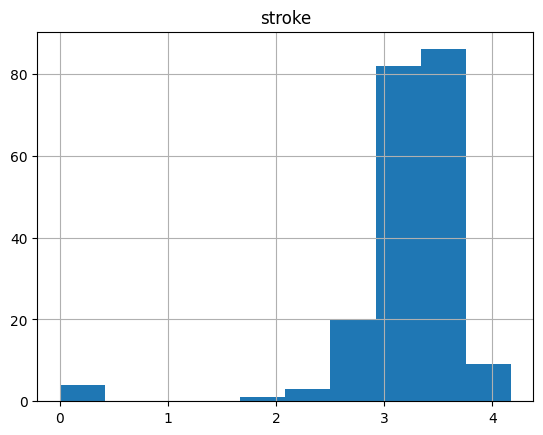

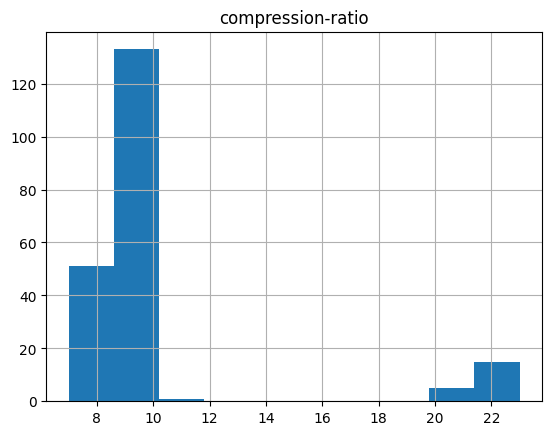

In [15]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

###Train your model with numeric features + normalization

In [27]:
## Your code goes here
# Batch size setting for training
batch_size = 16

# Displaying numeric feature names for verification
print("Numeric Feature Names:", numeric_feature_names)

# Separating the dataset into feature (X) and target (y) data
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Z-score normalization function
def z_score_normalize(df, epsilon=0.000001):
    """Performs Z-score normalization on a DataFrame."""
    return (df - df.mean()) / (df.std() + epsilon)

# Normalize the feature data (X) using Z-score
x_df_normalized = z_score_normalize(x_df)

# Create input functions to provide data to the Estimator during training and evaluation
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=x_df_normalized,       # normalized input features for training
    y=y_series,              # target values (price)
    batch_size=batch_size,
    num_epochs=None,         # Continue until specified steps are reached
    shuffle=True             # Randomize the order of data for better generalization
)

eval_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=x_df_normalized,       # normalized input features for evaluation
    y=y_series,
    batch_size=batch_size,
    shuffle=False            # Keep data in order for evaluation
)

predict_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=x_df_normalized,       # normalized input features for prediction
    batch_size=batch_size,
    shuffle=False            # Keep data in order for prediction
)

# Define feature columns with Z-score normalization for each numeric feature
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (x_df.std()[feature_name] + epsilon)
    )
    for feature_name in numeric_feature_names
]
print('Model Feature Columns:', model_feature_columns)

# Set up the model with chosen hyperparameters and Adagrad optimizer
est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],                         # Single hidden layer with 64 units
    optimizer=tf.compat.v1.train.AdagradOptimizer(learning_rate=0.01),
)

# Train and evaluate the model in increments to observe training progress
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
    # Train model for a fraction of total steps, then evaluate
    est.train(train_input_fn, steps=num_training_steps // num_print_statements)
    scores = est.evaluate(eval_input_fn)

    # Display training metrics, including average loss and batch loss
    print("Training and Evaluation Scores:", scores)

Numeric Feature Names: ['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
Model Feature Columns: [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7b1413586b00>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7b1413586a70>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7b14135869e0>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7b1413586950>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7b1413586f80>), NumericColumn(key='height'

['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7b1415d39990>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7b1415d39480>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7b1415d39630>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7b1415d38a60>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7b1415d391b0>), NumericColumn(key='height', shape=(1,), default_va

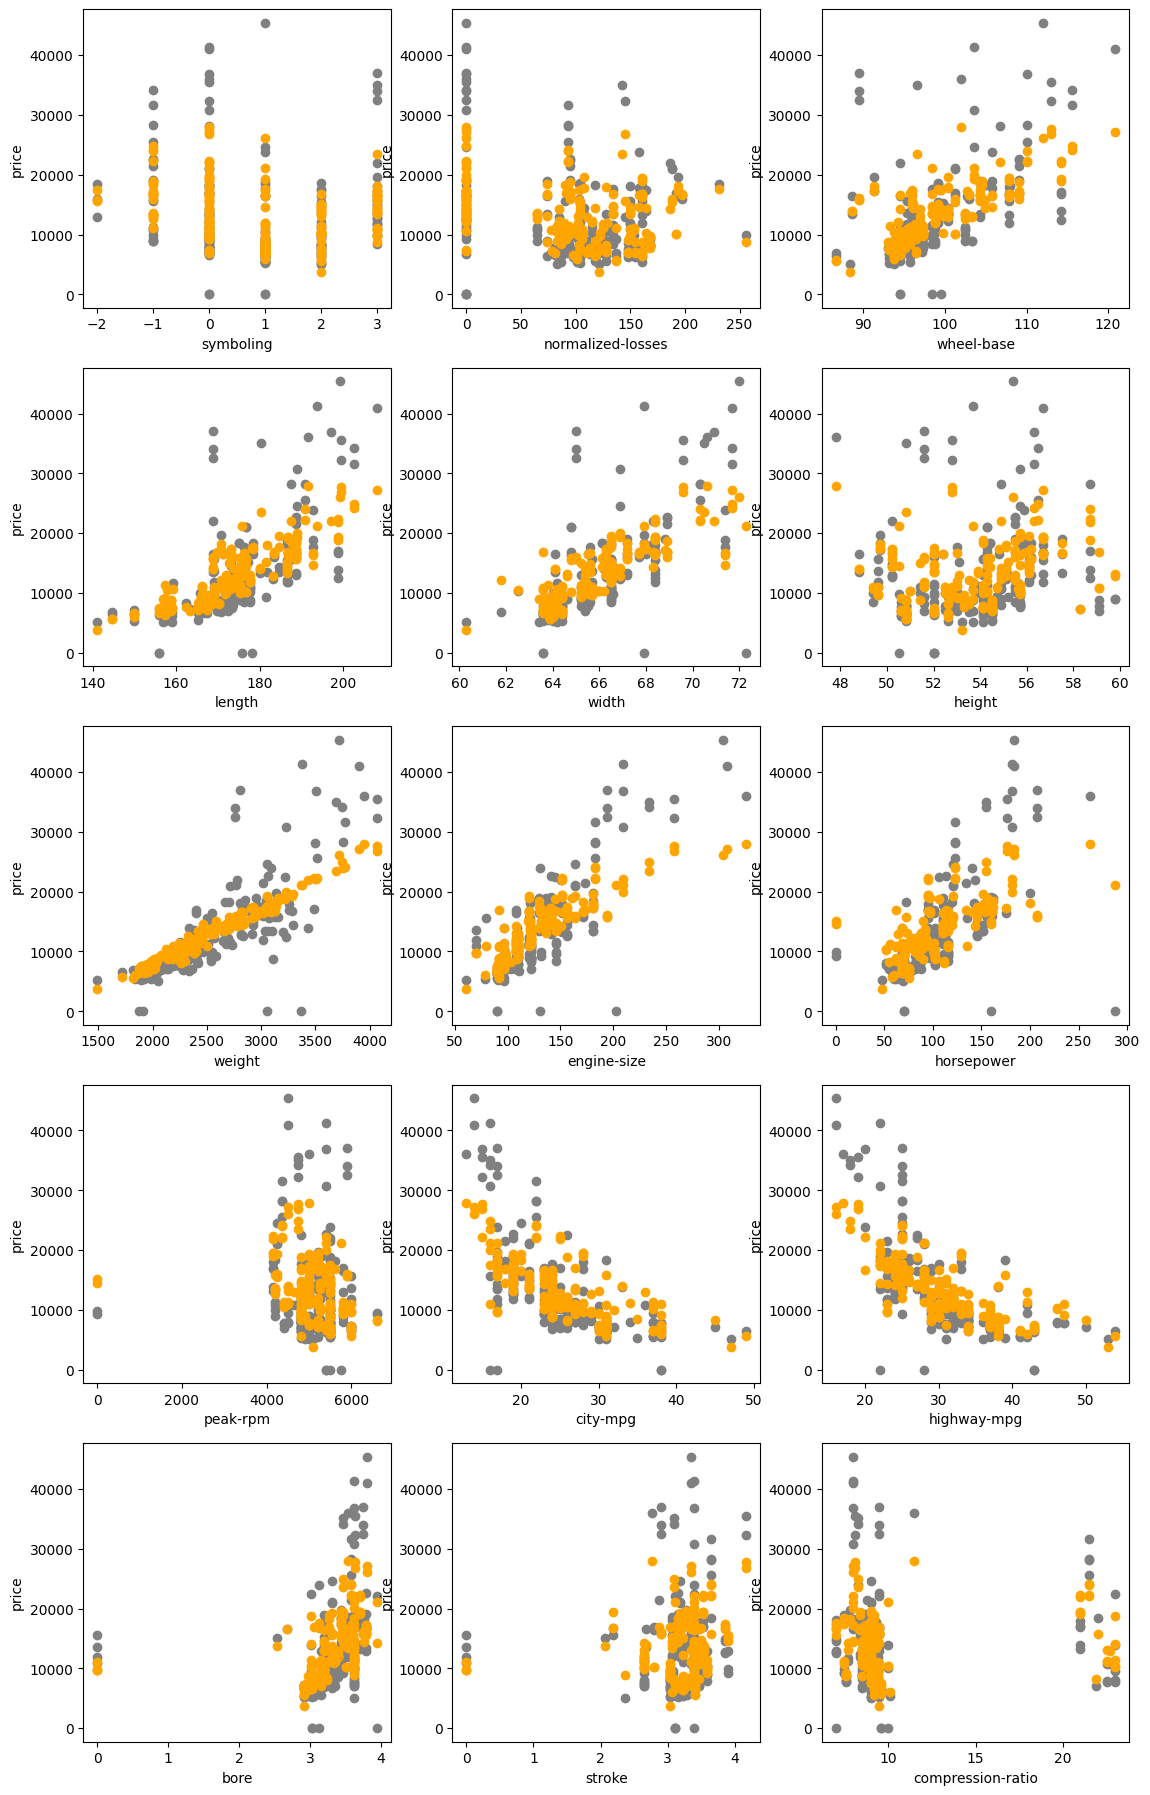

In [28]:
#@title Possible solution
# This does Z-score normalization since the distributions for most features looked
# roughly normally distributed.

# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption. Epsilon prevents divide by zero.

# With normalization, are you able to get the model working with
# GradientDescentOptimizer? Z-score normalization doesn't seem to be able to get
# SGD working. Maybe a different type of normalization would?

batch_size = 16

print(numeric_feature_names)
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Epsilon prevents divide by zero.
epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 3: Make your best model using only categorical features

- Look at the possible feature columns for categorical features. They begin with `categorical_column_with_` in go/tf-ops.
- You may find `dataframe[categorical_feature_names].unique()` helpful.


In [2]:
## Your code goes here
# Assuming car_data and categorical_feature_names are defined
batch_size = 16
# Extract features and labels
x_df = car_data[categorical_feature_names]
y_series = car_data['price']

# Create input functions for training, evaluation, and prediction
def create_input_fn(features, labels=None, batch_size=16, num_epochs=None, shuffle=True):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(
        x=features,
        y=labels,
        batch_size=batch_size,
        num_epochs=num_epochs,
        shuffle=shuffle
    )

train_input_fn = create_input_fn(x_df, y_series, batch_size=batch_size, num_epochs=None, shuffle=True)
eval_input_fn = create_input_fn(x_df, y_series, batch_size=batch_size, shuffle=False)
predict_input_fn = create_input_fn(x_df, batch_size=batch_size, shuffle=False)

# Define feature columns for categorical features
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()
        )
        ) for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

# Define the DNNRegressor with the AdagradOptimizer
estimator = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.compat.v1.train.AdagradOptimizer(learning_rate=0.01),
)

# Training and evaluation loop
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
    estimator.train(train_input_fn, steps=num_training_steps // num_print_statements)
    scores = estimator.evaluate(eval_input_fn)










NameError: name 'car_data' is not defined

In [3]:
#@title Possible solution
# We have the full list of values that each feature takes on, and the list is
# relatively small so we use categorical_column_with_vocabulary_list.

batch_size = 16

x_df = car_data[categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)



NameError: name 'car_data' is not defined

## Task 4: Using all the features, make the best model that you can make

With all the features combined, your model should perform better than your earlier models using numerical and categorical models alone. Tune your model until that is the case.

In [26]:
## Your code goes here
# Assuming car_data, numeric_feature_names, and categorical_feature_names are defined
batch_size = 16

# Combine numeric and categorical feature names for the dataframe
x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

# Function to create input functions
def create_input_fn(features, labels=None, batch_size=16, num_epochs=None, shuffle=True):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(
        x=features,
        y=labels,
        batch_size=batch_size,
        num_epochs=num_epochs,
        shuffle=shuffle
    )

train_input_fn = create_input_fn(x_df, y_series, batch_size=batch_size, num_epochs=None, shuffle=True)
eval_input_fn = create_input_fn(x_df, y_series, batch_size=batch_size, shuffle=False)
predict_input_fn = create_input_fn(x_df, batch_size=batch_size, shuffle=False)

# Epsilon to prevent divide by zero
epsilon = 0.000001

# Define feature columns for both numeric and categorical features
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()
        )
    ) for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=lambda val: (val - x_df.mean()[feature_) / (epsilon + x_df.std()[feature_name])
    ) for feature_name in numeric_feature_names
]

print('model_feature_columns', model_feature_columns)

# Define the DNNRegressor with the AdagradOptimizer
estimator = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.compat.v1.train.AdagradOptimizer(learning_rate=0.01),
)

# Training and evaluation loop
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
    estimator.train(train_input_fn, steps=num_training_steps // num_print_statements)
    scores = estimator.evaluate(eval_input_fn)




model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-doors', vocabulary_list=('four', 'two', '?'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=('gas', 'diesel'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('jaguar', 'peugot', 'volkswagen', 'mitsubishi', 'audi', 'renault', 'subaru', 'dodge', 'mazda', 'honda', 'bmw', 'chevrolet', 'isuzu', 'toyota', 'mercedes-benz', 'nissan', 'plymouth', 'saab', 'volvo', 'alfa-romero', 'porsche', 'mercury'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='body-style', vocabulary_list=('sedan', 'wagon', 'hatchback', 'convertible', 'hardtop'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(cat

TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/tensorflow_estimator/python/estimator/canned/dnn.py", line 240, in call  *
        net = self._input_layer(features)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer_v1.py", line 838, in __call__  **
        outputs = call_fn(cast_inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/feature_column/dense_features.py", line 184, in call  **
        tensor = column.get_dense_tensor(
    File "<ipython-input-26-a25de7189cfe>", line 36, in <lambda>
        normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name])
    File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 11693, in mean
        result = super().mean(axis, skipna, numeric_only, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 12420, in mean
        return self._stat_function(
    File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 12377, in _stat_function
        return self._reduce(
    File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 11562, in _reduce
        res = df._mgr.reduce(blk_func)
    File "/usr/local/lib/python3.10/dist-packages/pandas/core/internals/managers.py", line 1500, in reduce
        nbs = blk.reduce(func)
    File "/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py", line 404, in reduce
        result = func(self.values)
    File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 11481, in blk_func
        return op(values, axis=axis, skipna=skipna, **kwds)
    File "/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py", line 147, in f
        result = alt(values, axis=axis, skipna=skipna, **kwds)
    File "/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py", line 404, in new_func
        result = func(values, axis=axis, skipna=skipna, mask=mask, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py", line 720, in nanmean
        the_sum = _ensure_numeric(the_sum)
    File "/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py", line 1686, in _ensure_numeric
        raise TypeError(f"Could not convert {x} to numeric")

    TypeError: Could not convert ['fourfourfourtwofourtwotwo??fourtwotwotwofourfourfourfourtwofourfourtwofourfourfourtwotwotwotwofourtwotwofourfourtwofourfourfourtwotwotwofourtwofourfourtwofourfourfourtwotwotwotwofourtwofourfourfourfourfourfourfourtwotwofourtwofourfourfourtwotwofourtwotwotwofourfourfourfourtwofourfourfourtwofourtwofourtwotwofourtwotwotwofourfourfourtwotwofourfourfourtwotwotwotwotwofourfourtwotwofourfourtwofourtwofourfourfourtwofourfourfourfourtwotwotwofourfourfourfourtwofourtwofourfourfourfourfourfourtwofourfourfourtwotwotwotwofourfourtwofourtwotwofourfourfourtwotwofourtwofourfourtwotwofourfourfourfourtwofourtwofourtwofourfourfourfourtwotwotwotwotwofourtwotwofourtwofourfourtwotwotwotwofourtwofourfourfourfourtwofourfourfourfourfourtwo'
     'gasgasdieselgasgasgasgasgasdieselgasgasgasgasdieselgasdieselgasgasgasgasgasdieselgasgasdieselgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasdieselgasgasgasgasgasgasdieselgasgasgasgasgasgasdieselgasgasgasgasgasgasgasdieselgasdieselgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasdieselgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasdieselgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasdieselgasdieselgasdieselgasgasgasgasdieselgasgasgasgasgasgasgasgasgasgasgasgasgasgasdieselgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasdieselgasgasgasgasgasgasgasgasgasgasgasgasgasgasgasdieselgasgasgasgasgasgasgas'
     'jaguarpeugotvolkswagenmitsubishiaudirenaultsubarudodgemazdavolkswagenhondabmwmazdapeugotchevroletvolkswagenbmwisuzuauditoyotavolkswagenpeugotmazdamercedes-benzvolkswagensubarunissanmazdanissandodgeplymouthsubarusaabvolkswagenplymouthtoyotatoyotatoyotamitsubishivolkswagenvolvomazdabmwnissanmazdaplymouthnissanvolvonissantoyotaauditoyotapeugotnissanvolkswagennissanmazdamazdadodgebmwpeugotmitsubishinissansubarunissandodgetoyotatoyotaisuzumitsubishisubarutoyotamitsubishimitsubishivolkswagentoyotaaudimazdaalfa-romerohondaplymouthvolvotoyotatoyotamitsubishijaguarbmwtoyotanissanmazdadodgetoyotamazdamercedes-benzisuzuaudihondaisuzutoyotahondaporschedodgetoyotasaabhondatoyotapeugotnissanporschemazdahondaalfa-romerovolvoplymouthtoyotaaudibmwhondatoyotatoyotahondavolkswagenhondamitsubishitoyotatoyotanissanvolvopeugotbmwmitsubishidodgemercedes-benzmitsubishivolvosubarupeugottoyotamercurynissansubarupeugotmazdaporschenissannissanpeugotbmwchevroletvolkswagenplymouthalfa-romeronissansaabplymouthtoyotamercedes-benzvolvomazdamercedes-benzvolvomazdamercedes-benzmazdatoyotatoyotapeugottoyotasubarutoyotasaabtoyotaaudimitsubishisubaruvolvochevroletporschemazdahondahondamercedes-benznissantoyotadodgemercedes-benzhondadodgeporschesubarusaabmitsubishinissanhondasubarutoyotavolvovolkswagensaabmitsubishivolvotoyotasubarurenaultjaguar'
     'sedanwagonsedanhatchbacksedanhatchbackhatchbacksedansedansedanhatchbacksedanhatchbacksedansedansedansedanhatchbackwagonhatchbacksedansedansedansedansedanhatchbackhatchbackhatchbackwagonhatchbackhatchbackwagonsedanhatchbackhatchbacksedansedanhatchbackhatchbackconvertiblesedanhatchbacksedansedanhatchbacksedansedanwagonhatchbackhardtopsedansedansedansedansedansedansedansedanhatchbacksedanwagonhatchbacksedansedansedansedanwagonhatchbacksedanhatchbacksedanhardtophatchbackhatchbacksedansedansedansedanhatchbacksedansedanwagonsedanwagonhatchbacksedansedanhardtopwagonhatchbackhatchbackhatchbackhatchbackwagonsedanhatchbackhatchbacksedansedansedanhardtophatchbackconvertiblehatchbackhatchbackhatchbacksedanhatchbackhatchbacksedanwagonconvertiblesedanhatchbacksedansedansedansedanwagonhatchbacksedansedanhatchbackhatchbackhatchbackhatchbackhatchbackwagonsedansedansedanhatchbacksedansedansedansedanwagonwagonhatchbacksedanwagonsedanhatchbackhatchbacksedanhardtopsedansedanhatchbackwagonhatchbackconvertiblesedansedanwagonhatchbackhardtopsedanhatchbacksedansedanhatchbackconvertiblesedansedanhatchbackwagonhatchbackwagonhatchbacksedanhatchbacksedansedansedansedanhatchbackhardtophatchbackhatchbackhatchbacksedanhatchbackhatchbackwagonhardtopsedansedanconvertiblehatchbackhatchbackhatchbackwagonhatchbacksedansedansedansedanhatchbacksedansedansedanwagonwagonsedan'
     'frontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontrearfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontrearfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontrearfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfrontfront'
     'mpfimpfiidispdimpfimpfi2bblmpfiidimpfi1bblmpfi2bblidi2bblidimpfispfimpfimpfimpfiidi2bblmpfiidi2bblmpfimpfimpfi2bbl2bblmpfimpfimpfi2bbl2bblmpfimpfispdimpfimpfi4bblmpfi2bbl4bbl2bblmpfimpfimpfimpfimpfi2bblmpfiidimpfimpfi2bbl2bbl2bblmpfiidi2bbl2bbl2bbl2bbl2bbl2bblidi2bblspdimpfimpfi2bbl2bblmpfiidimpfiidimpfimpfi2bblmpfimpfimpfi2bblmpfimpfimpfi2bbl2bbl2bblmpfi2bblidi2bblmpfi1bbl2bblmpfi1bblmpfimpfimpfimpfi1bbl2bblmpfimpfimpfi2bbl1bblmpfimpfispdiidimpfimpfi2bbl2bblmpfi1bblmpfi1bblspdimpfi2bbl2bblmpfimpfimpfispdimfiidispdiidimpfiidi2bblmpfi2bbl2bblidi2bblmpfi2bbl2bblmpfimpfi2bblmpfispdimpfi2bblmpfi2bbl2bblidimpfi4bblmpfimpfi2bblmpfimpfimpfi2bblmpfimpfi2bbl2bblmpfi2bblmpfi2bbl2bblmpfi2bblmpfi2bbl1bbl1bblidi2bblmpfi2bblmpfi1bbl2bblmpfi2bblmpfispdi2bbl1bbl2bbl2bblmpfiidimpfi2bblmpfi2bblmpfimpfimpfi'
     'dohclohcohcohcohcohcfohcohcohcohcohcohclohcohcohcohcohcohcohclohcohcvohcohcfohcvrotorohcvohcohcohcfohcohcohcohcdohcdohcohcohcohcrotorohcohcrotorohcohcvohcohcvohcohcohclohcohcohcvohcohcohcohclohcohcohcfohcohcohcohcohcohcohcfohcohcohcohcohcohcohcohcvohcohcohcdohcdohcohcdohcohcohcohcohcohcohcohcohcohcohcohcohcohcohcohcfohcohcohcohcohclohcvdohcvohcohcdohcohcohcohcohcohcohcohcohcohcohcohcohcdohcohcohcohclohcohcohcohcohcohcohcflohcohcohcohcflohcohcohcohclohclohcohcdohcohcdohcohcohcohcohcrotorohcvohcvohcohcvohcohcohclohcohcfohcohcohcohcohcohcfohcohcohcfohcohcohcohcohcdohcohcohcvohcohcohcfohcfdohcohcohcohcohcfohcohcohcohcohcohcohcohcfohcohcv'
     'stdstdturboturbostdstdstdturbostdstdstdstdstdturbostdstdstdstdstdstdstdturbostdstdstdstdstdstdstdstdstdturbostdstdstdstdstdstdturbostdturbostdstdstdstdstdstdstdturbostdstdstdturbostdstdstdstdstdstdstdturbostdstdstdstdstdstdstdstdturbostdstdstdstdstdturboturbostdstdstdstdturbostdstdstdstdstdstdstdstdstdstdstdturbostdturbostdstdstdstdstdturbostdstdstdstdstdstdstdstdstdstdstdturbostdstdstdstdstdstdstdstdstdturbostdstdstdstdstdstdstdturboturboturboturboturboturbostdturbostdstdturbostdstdstdstdstdstdstdstdturbostdstdturbostdstdturboturbostdstdstdstdstdstdstdstdstdstdstdstdstdstdstdstdstdstdstdstdstdstdstdturbostdstdstdstdstdstdstdstdturboturbostdstdstdstdturboturbostdstdstdstdstdstdstd'
     'sixfourfourfourfivefourfourfourfourfourfoursixfourfourfourfoursixfourfivefourfourfourfoureightfourfoursixtwosixfourfourfourfourfourfourfoursixfourfourfourfourtwosixfourtwofoursixfoursixfourfivefourfourfourfoursixfourfourfoursixfourfourfourfourfourfourfourfourfourfourfourfourfourfourfivefourfivefoursixfourfourfourfoursixfoursixsixfourfourfourfourfourfourfivefourfivefourfourfourfoursixfourfourfourfourfourfoursixeightfourfourfourfourfourfourfivesixfourfourfourfourfourfourfoursixfourfourfourfourfourfourfourfivefoursixfourfourfourfourfourfourfourfourfourfourfourfourfourthreefourfourfourfourfourfourfourfivefourtwoeightsixfoureightfourfourfourfourfourfourfourfourfourfourfourfourfourfoursixfourfourfourfivefoursixfoureightfourfoursixfourfourfourfourfourfourfourfourfourfourfourfourfourfourfourtwelve'
     'rwdrwdfwdfwdfwdfwd4wdfwdfwdfwdfwdrwdfwdrwdfwdfwdrwdrwdfwdfwdfwdrwdfwdrwdfwdfwdrwdrwdfwdfwdfwd4wdfwdfwdfwdfwdrwdrwdfwdfwdrwdrwdrwdfwdrwdfwdfwdrwdrwdrwdfwdrwdrwdfwdfwdfwdfwdfwdfwdrwdrwdfwdfwdfwdfwdfwdfwdfwdfwdfwdfwdrwdfwdfwdfwdfwdfwdrwdrwdfwdfwdrwdrwdrwdfwdrwdrwdrwdfwdfwdfwdrwdfwdrwdrwd4wdfwdfwdfwdfwdrwdfwdrwdfwdfwdfwdrwdrwdrwdfwdfwdrwdrwdrwdfwd4wdrwdfwd4wdfwdfwdfwdfwdfwdrwdfwdfwdrwdrwdrwdfwdfwdrwdfwdrwd4wdrwd4wdrwdfwd4wdrwdfwdrwdfwdfwdrwdrwdfwdfwdfwdrwdfwdfwdfwdfwdrwdrwdrwdrwdrwdfwdrwdrwdfwdfwdrwdrwdfwdfwdfwdrwdfwdfwd4wdrwdfwdrwdfwdfwdfwdrwdfwdrwdfwdrwdfwdfwdrwdfwdfwdfwdfwdfwdfwdfwdrwdfwdfwdfwdrwdfwdfwdfwdrwd'] to numeric


In [ ]:
#@title Possible solution
# This is a first pass at a model that uses all the features.
# Do you have any improvements?

batch_size = 16

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

epsilon = 0.000001
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]


print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01),
  )

# TRAIN
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # The `scores` dictionary has several metrics automatically generated by the
  # canned Estimator.
  # `average_loss` is the average loss for an individual example.
  # `loss` is the summed loss for the batch.
  # In addition to these scalar losses, you may find the visualization functions
  # in the next cell helpful for debugging model quality.
  print('scores', scores)

